## plot the embedding vector in the embedding space.

In [2]:
from transformers import AutoTokenizer, AutoModel
import torch
import torch.nn.functional as F
from datasets import load_dataset, Dataset
import random
import numpy as np
from tqdm import tqdm
import os

# Set random seed for reproducibility
seed = 3
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
os.environ["CUDA_VISIBLE_DEVICES"] = "0,1,2,3,4,5,6,7"

# Set device (GPU if available)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Function to calculate cosine distance and return KNN indices (excluding the sample itself)
def cosDistance(chosen_embedding, rejected_embedding):

    # Compute cosine similarity and convert to cosine distance
    similarity_vector = torch.matmul(chosen_embedding, rejected_embedding)
    distance_vector = 1.0 - similarity_vector

    return distance_vector

# Mean pooling function to obtain sentence embeddings
def mean_pooling(model_output, attention_mask):
    token_embeddings = model_output[0]
    input_mask_expanded = attention_mask.unsqueeze(-1).expand(token_embeddings.size()).float()
    return torch.sum(token_embeddings * input_mask_expanded, 1) / torch.clamp(input_mask_expanded.sum(1), min=1e-9)

# Process dialog messages to convert into a text format
def process_dialog(dialog):
    chosen_text, rejected_text = "", ""
    
    for message in dialog['chosen']:
        if message['role'] == 'assistant':
            chosen_text += f"### {message['role']}: {message['content']}\n"
        
    for message in dialog['rejected']:
        if message['role'] == 'assistant':
            chosen_text += f"### {message['role']}: {message['content']}\n"
        
    return {"chosen_features": chosen_text, "rejected_features": rejected_text}

# Generate embeddings for text
def embed_chosen_text(batch):
    encoded_inputs = tokenizer(batch['chosen_features'], padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        model_outputs = model(**encoded_inputs)
    sentence_embeddings = mean_pooling(model_outputs, encoded_inputs['attention_mask'])
    embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    
    batch['chosen_embeddings'] = embeddings.cpu().numpy().tolist()
    return batch

def embed_rejected_text(batch):
    encoded_inputs = tokenizer(batch['rejected_features'], padding=True, truncation=True, return_tensors="pt").to(device)
    with torch.no_grad():
        model_outputs = model(**encoded_inputs)
    sentence_embeddings = mean_pooling(model_outputs, encoded_inputs['attention_mask'])
    embeddings = F.normalize(sentence_embeddings, p=2, dim=1)
    
    batch['rejected_embeddings'] = embeddings.cpu().numpy().tolist()
    return batch

##############################################################################################################################

# Set dataset parameters
k_near = 10
dataset_size = 1000


embedding_data_name = 'ultrafeedback_embeddings.parquet'
# embedding_data_name = 'ultrafeedback_embeddings_llama8b.parquet'
# embedding_model_name = "BAAI/bge-large-en-v1.5"
embedding_model_name = 'princeton-nlp/Llama-3-Base-8B-SFT'

if not os.path.exists(embedding_data_name):

    dataset = load_dataset('json', data_files="ultrafeedback_with_learning_order.json")

    dataset['train'] = dataset['train'].map(process_dialog, batched=False)


    tokenizer = AutoTokenizer.from_pretrained(embedding_model_name)
    model = AutoModel.from_pretrained(embedding_model_name).to(device)
    model = torch.nn.DataParallel(model)

    dataset['train'] = dataset['train'].map(embed_chosen_text, batched=True, batch_size=1)
    dataset['train'] = dataset['train'].map(embed_rejected_text, batched=True, batch_size=1)

    dataset['train'].to_parquet(embedding_data_name)
    print(f"Embeddings saved to {embedding_data_name}")




#########################################################################################################################




# Load generated embeddings dataset
embedding_dataset = load_dataset('parquet', data_files=f'ultrafeedback_embeddings.parquet')['train']

# # Get all embeddings data
# chosen_embeddings = torch.tensor(embedding_dataset['chosen_embeddings']).to(device)
# rejected_embeddings = torch.tensor(embedding_dataset['rejected_embeddings']).to(device)

all_embeddings = embedding_dataset['chosen_embeddings'].append(embedding_dataset['rejected_embeddings'])
all_embeddings = torch.tensor(all_embeddings).to(device)


all_knn_distances={}

for label in ['chosen', 'rejected']:

    # Select subset of samples based on quality
    if label == 'chosen':
        embedding_subset = embedding_dataset['chosen_embeddings']
    else:
        embedding_subset = embedding_dataset['rejected_embeddings']

    distances = []
    for sample_idx, sample in enumerate(tqdm(embedding_subset, desc=f"Processing samples (label={label})")):
        sample_embedding = torch.tensor(sample['embeddings']).to(device)

        # Calculate cosine distance for the sample and retrieve KNN indices
        dist = cosDistance(sample_embedding, all_embeddings, k_near=k_near)
        distances.append(dist)
        
    all_knn_distances[label] = distances



Using device: cuda


## PCA

In [ ]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import numpy as np
from datasets import load_dataset

# Load the generated embeddings dataset
dataset_name = "ultrafeedback"  # Replace with your dataset name
embedding_dataset = load_dataset('parquet', data_files=f'{dataset_name}_embeddings.parquet')['train']

# Assume 'labels' is already defined and contains label information for each sample

# Extract embeddings of samples with label 5
pca_embeddings = embedding_dataset['chosen_embeddings']

chosen_embeddings = embedding_dataset['chosen_embeddings']
rejected_embeddings = embedding_dataset['rejected_embeddings']

# 拼接两个 embedding
all_embeds = np.concatenate([chosen_embeddings, rejected_embeddings], axis=0)
labels = np.array([1]*len(chosen_embeddings) + [0]*len(rejected_embeddings))  # 1: chosen, 0: rejected

# 做 PCA 降维到二维
pca = PCA(n_components=2)
embeds_2d = pca.fit_transform(all_embeds)

# 可视化
plt.figure(figsize=(8,6))
plt.scatter(embeds_2d[labels==0, 0], embeds_2d[labels==0, 1], c='red', label='Rejected', alpha=0.6)

plt.scatter(embeds_2d[labels==1, 0], embeds_2d[labels==1, 1], c='blue', label='Chosen', alpha=0.6)
plt.legend()
plt.title('PCA of Chosen vs. Rejected Embeddings')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.grid(True)
plt.tight_layout()
plt.show()


: 

### PCA Visualization of All Embeddings

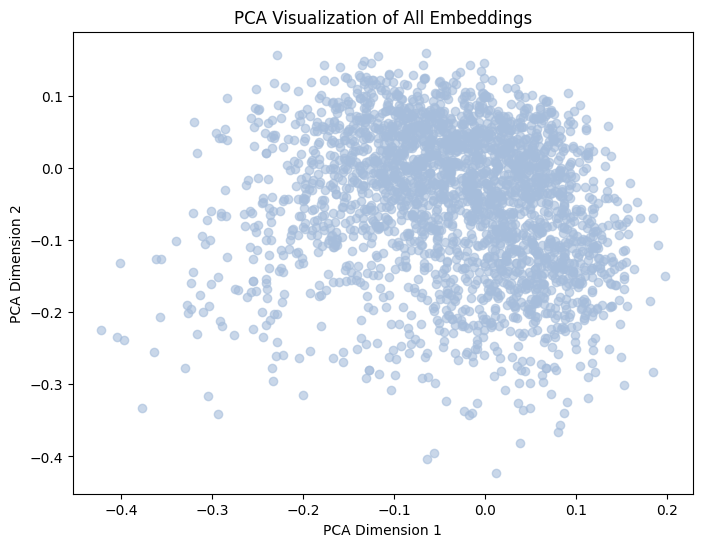

In [60]:
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import numpy as np

# Standardize and apply PCA to reduce embeddings to 2D space
scaler = StandardScaler()
all_embeddings = np.array(pca_embeddings)  # Convert embeddings to a NumPy array if not already
all_embeddings = scaler.fit_transform(all_embeddings)  # Standardize embeddings

# Use the previously trained PCA model to transform the embeddings
embeddings_2d = pca.transform(all_embeddings)

# Plot the 2D scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], alpha=0.6, color='#a6bddb')  # Adjust color and transparency

# Set title and labels for the plot
plt.title("PCA Visualization of All Embeddings")
plt.xlabel("PCA Dimension 1")
plt.ylabel("PCA Dimension 2")

# Show the plot
plt.show()


In [ ]:
from scipy.spatial.distance import cdist

chosen_mean = np.mean(chosen_embeddings, axis=0)
rejected_mean = np.mean(rejected_embeddings, axis=0)

# 类内平均距离
intra_chosen = np.mean(cdist(chosen_embeddings, [chosen_mean]))
intra_rejected = np.mean(cdist(rejected_embeddings, [rejected_mean]))

# 类间距离
inter_class = np.linalg.norm(chosen_mean - rejected_mean)

print(f"Intra-class (chosen): {intra_chosen:.4f}")
print(f"Intra-class (rejected): {intra_rejected:.4f}")
print(f"Inter-class distance: {inter_class:.4f}")
